#Procesamiento de datos del Visound
Esta rutina procesa y visualiza los datos que se generan con el programa visound.
La app va subiendo los datos a un servidor. Este servidor corre en una virtual machine en la compu de casa sobre un ubuntu server en el que instale un json-server. 
Esta rutina descarga los datos del servidor en su ultima version y los procesa para hacer una visualizacion de la actividad de los usuarios en forma grafica (un timeline de la actividad)

In [68]:
%matplotlib inline
from IPython import embed
from IPython.display import display
from graficos import *
from load import *
from DownloadFile import *

# Recoleccion de datos

Bajamos la ultima version del archivo de internet y nos fijamos de guardar la version anterior con una marca temporal

In [69]:
DownloadFile ()

Donload finish


In [70]:
touchs, sounds = load(3)

recursos cargados del archivo


Index(['categoriasTouched', 'idResourceTouched', 'isTrue', 'jsonMetaData',
       'jsonMetaDataTouched', 'touchInstance', 'trialInstance',
       'categoriasElementos', 'categoriasEstimulo', 'categoriasRta',
       'idRtaCorrecta', 'jsonMetaDataRta', 'jsonTrial', 'levelInstance',
       'resourcesIdSort', 'timeTrialExit', 'timeTrialStart', 'tipoDeTrial',
       'trialCompleted', 'trialId', 'trialTitle', 'levelCompleted', 'levelId',
       'levelTitle', 'sessionInstance', 'timeLevelExit', 'timeLevelStarts',
       'codeVersion', 'idEnvio_p', 'userID', 'Alias'],
      dtype='object')

# Con los datos ya cargados graficamos los resultados

La idea de esta seccion es hacer un analisis visual de los datos. Para eso vamos a armar un timeline donde vamos a mostrar con dibujos (lines, rectangulos, etc) lo que va pasando en el juego en funcion de diferentes criterios. Para un usuario cuando jugo, en usa sesion que paso, etc.

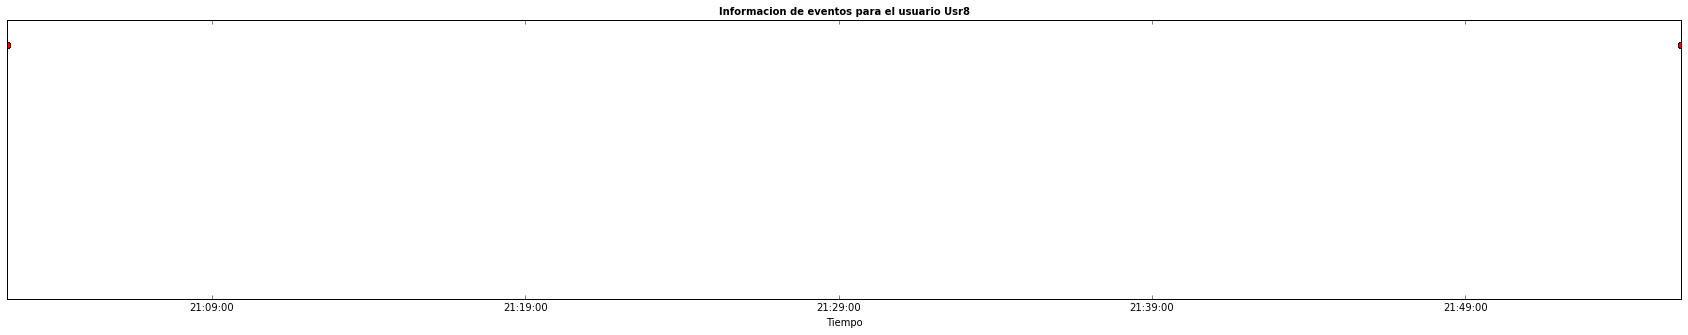

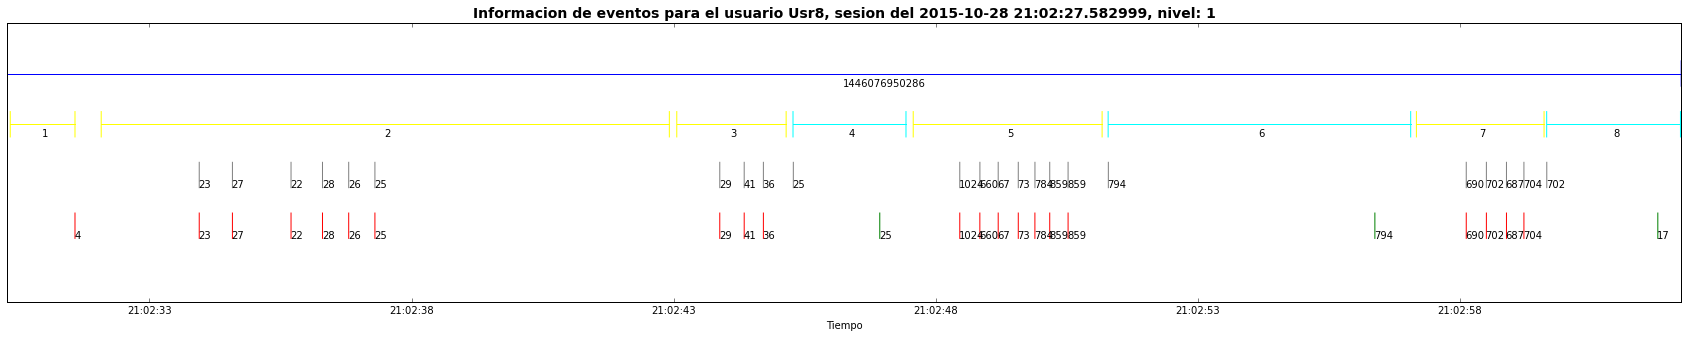

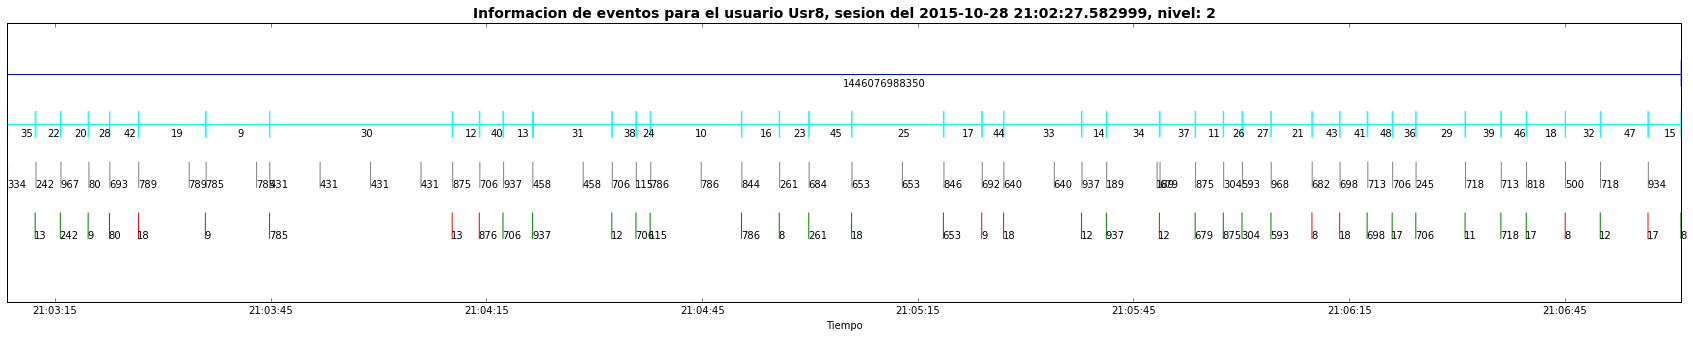

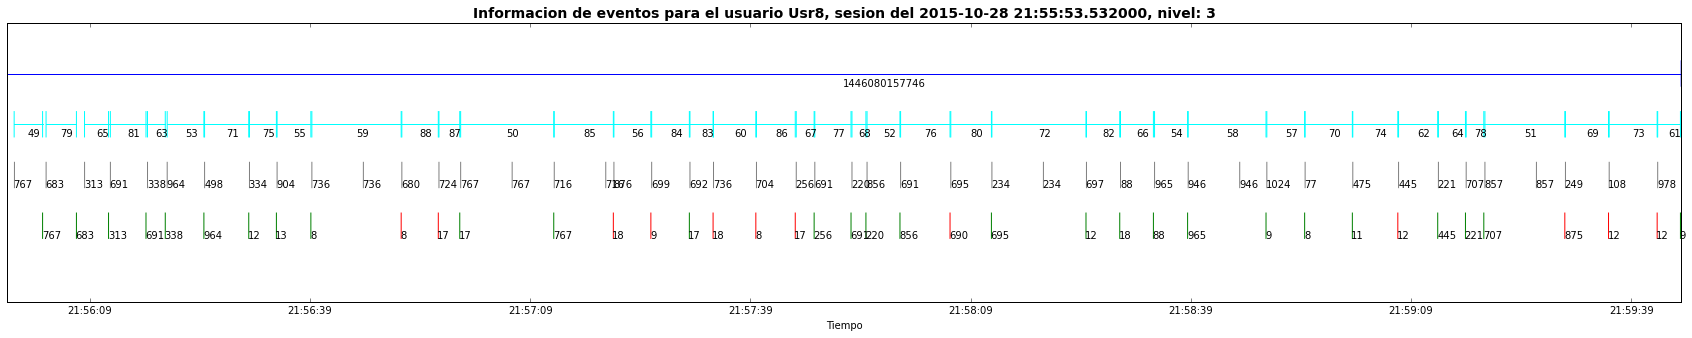

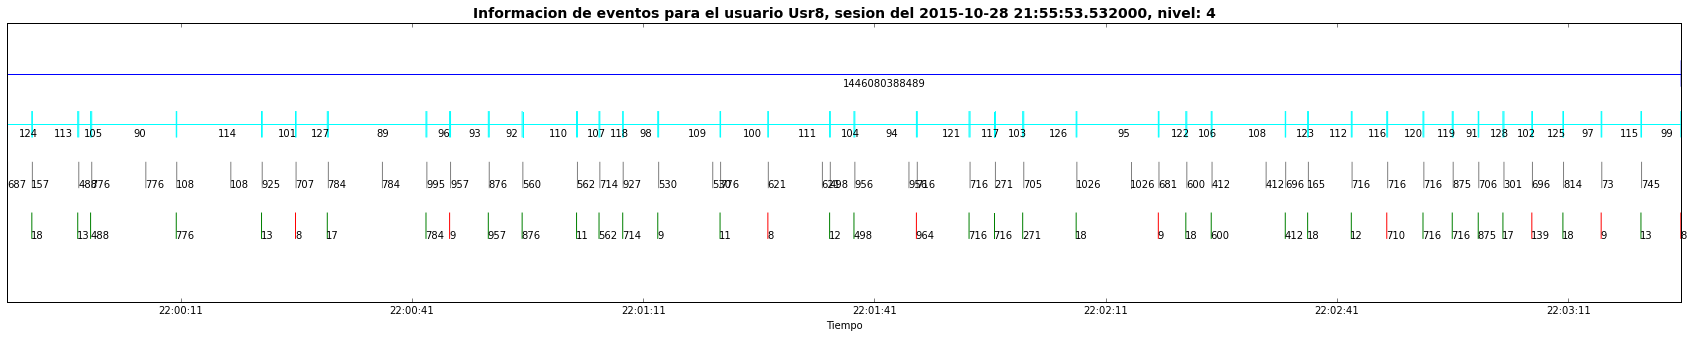

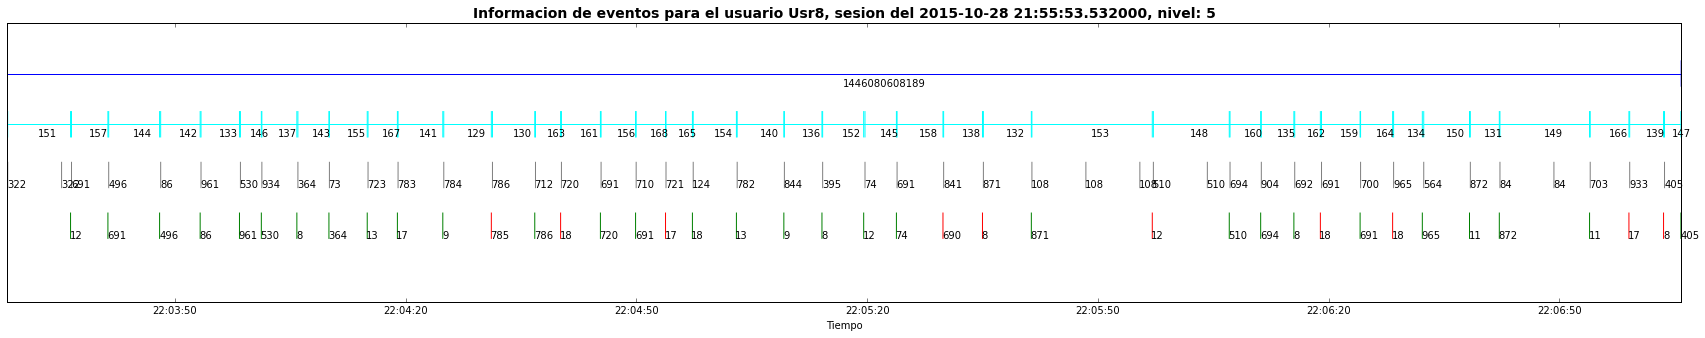

In [71]:
makeTimeline (touchs, sounds)

# Cosas de estadistica

En esta seccion se va a hacer un procesamiento estidistico de los datos para evaluar los resultados en funcion de diferentes parametros.


'Se hara la estadistica del usuario: Usr8'

'El usuario Usr8 jugo 2 veces'

'En la session 2015-10-28 21:02:27.582999 el usuario Usr8 jugo 2 niveles'

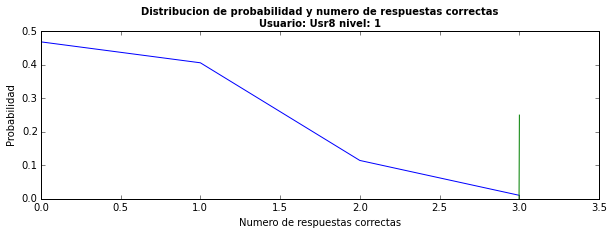

haciendo el analisis para la dificultad -1.0


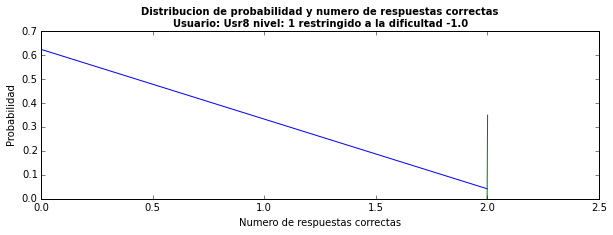

haciendo el analisis para la dificultad 3.0


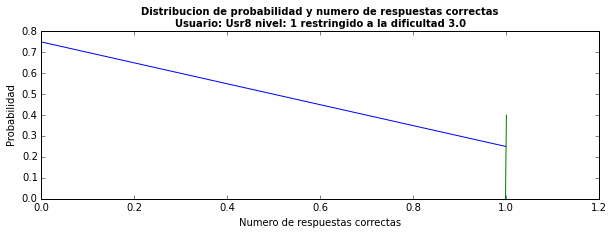

/home/ionatan/anaconda/envs/py34/lib/python3.4/site-packages/pandas/core/indexing.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


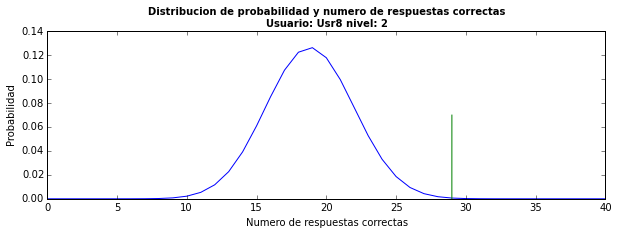

haciendo el analisis para la dificultad -1.0


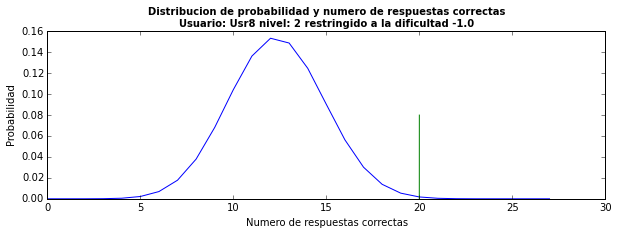

haciendo el analisis para la dificultad 1.0


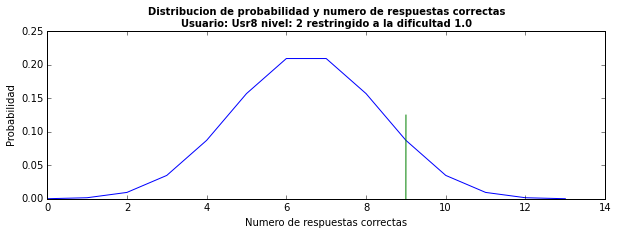

'En la session 2015-10-28 21:55:53.532000 el usuario Usr8 jugo 3 niveles'

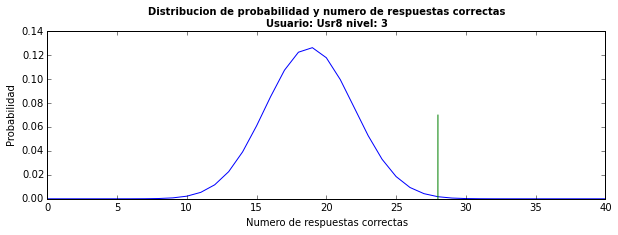

haciendo el analisis para la dificultad 4.0


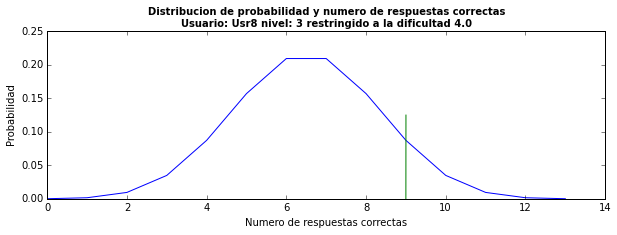

haciendo el analisis para la dificultad -1.0


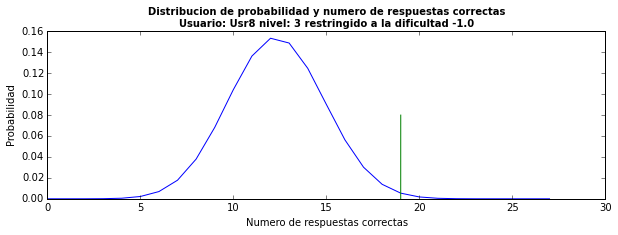

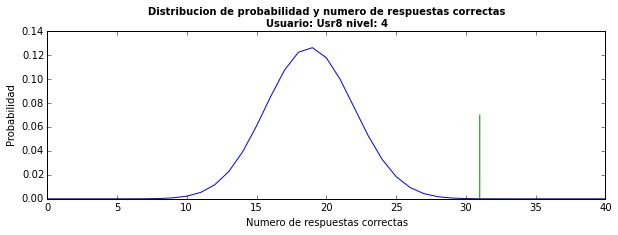

haciendo el analisis para la dificultad -1.0


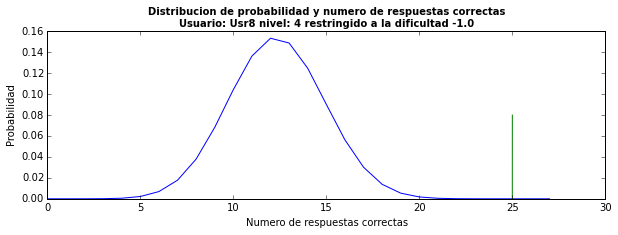

haciendo el analisis para la dificultad 7.0


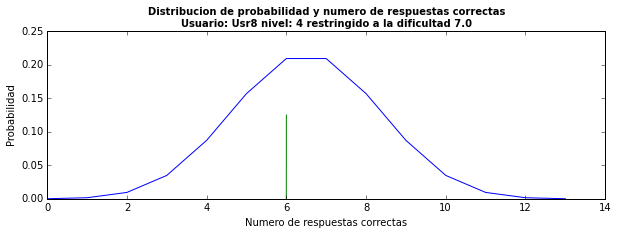

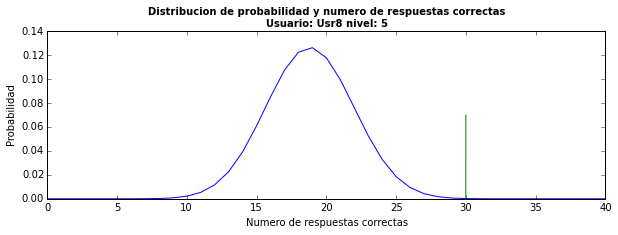

haciendo el analisis para la dificultad -1.0


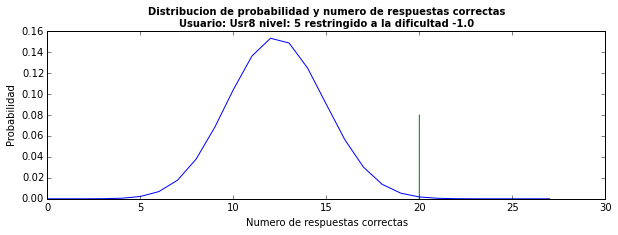

haciendo el analisis para la dificultad 9.0


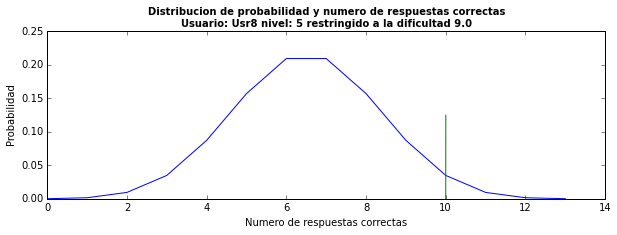

In [72]:
from Scripts import fechaLocal
from Scripts import makeHistogramaTrials
from Scripts import distribucionDeProbabilidadRandom
from Scripts import findTrueFirstTouch

import matplotlib.pyplot as plt
import pandas as pd

for usuario in touchs['Alias'].unique():
    display ('Se hara la estadistica del usuario: '+usuario)
    touchsUsuario = touchs[touchs['Alias']==usuario]
    display ('El usuario '+usuario+' jugo '+str(len(touchsUsuario['sessionInstance'].unique()))+' veces')
    for session in touchsUsuario['sessionInstance'].unique():
        touchsSession = touchsUsuario[touchsUsuario['sessionInstance']==session]
        
        # Analizamos los datos para dificultad generica
        display ('En la session '+ str(fechaLocal(session))+ ' el usuario '+str(usuario)+' jugo '+str(len(touchsSession['levelInstance'].unique())) + ' niveles')
        for level in touchsSession['levelInstance'].unique():
            
            touchsLevel = touchsSession[touchsSession['levelInstance']==level]
            levelInfo = touchsLevel.iloc[0]
            touchsLevelTest = touchsLevel[touchsLevel['tipoDeTrial']=='TEST']


            # Extraemos la info de dificultad json del trial
            temp = pd.DataFrame(columns=['dificultadTrial'])
            for (i,r) in touchsLevelTest.iterrows():
                e = r['jsonTrial']
                temp.loc[i] = [e['dificultad']['dificultad']]
            touchsLevelTest = pd.concat([touchsLevelTest, temp], axis=1)
            # Extraemos la info de dificultad json del estimulo
            temp = pd.DataFrame(columns=['dificultadEstimulo'])
            for (i,r) in touchsLevelTest.iterrows():
                e = r['jsonMetaDataRta']
                temp.loc[i] = [e['nivelDificultad']]
            touchsLevelTest = pd.concat([touchsLevelTest, temp], axis=1)
            # Creamos un marcador de dificultad real (porque el del estimulo falla si es 0 pero el del trial falla si el del estimulo es -1)
            touchsLevelTest['dificultadGlobal'] = touchsLevelTest['dificultadEstimulo']
            for (i,r) in touchsLevelTest.iterrows():
                if touchsLevelTest['dificultadEstimulo'].loc[i] == 0:
                    touchsLevelTest['dificultadGlobal'].loc[i] = touchsLevelTest['dificultadTrial'].loc[i]
            
            histograma = makeHistogramaTrials(touchsLevelTest)
            distribucion = distribucionDeProbabilidadRandom(histograma)
            # Armamos el grafico
            fig = plt.figure(figsize=(10,3))
            ax = fig.add_subplot(111)
            title = 'Distribucion de probabilidad y numero de respuestas correctas \n' + 'Usuario: '+str(usuario) + ' nivel: ' + str(levelInfo['levelId'])
            ax.set_title(title, fontsize=10, fontweight='bold')
            ax.set_xlabel('Numero de respuestas correctas')
            ax.set_ylabel('Probabilidad')
            x = range(len(distribucion))
            y = distribucion
            ax.plot(x,y)

            # Ahora agregamos la marca del numero obtenido, para eso primero hay que calcularlo
            aciertos = findTrueFirstTouch (touchsLevelTest)
            #aciertos = len(touchsLevelTest[touchsLevelTest['isTrue']==True])
            x=[aciertos-0.001,aciertos+0.001]        
            y=[0,ax.get_ylim()[1]/2]
            color = 'green'
            ax.plot(x,y,color)
            plt.show()

            
            # Repetimos los calculos para diferentes niveles de dificultad
            dificultades = touchsLevelTest['dificultadGlobal'].unique()
            for dificultad in dificultades:
                print ('haciendo el analisis para la dificultad '+str(dificultad))
                touchsDificultad = touchsLevelTest[touchsLevelTest['dificultadGlobal']==dificultad]
               
                histograma = makeHistogramaTrials(touchsDificultad)
                distribucion = distribucionDeProbabilidadRandom(histograma)
                # Armamos el grafico
                fig = plt.figure(figsize=(10,3))
                ax = fig.add_subplot(111)
                title = 'Distribucion de probabilidad y numero de respuestas correctas \n' + 'Usuario: '+str(usuario) + ' nivel: ' + str(levelInfo['levelId']) + ' restringido a la dificultad '+str(dificultad)
                ax.set_title(title, fontsize=10, fontweight='bold')
                ax.set_xlabel('Numero de respuestas correctas')
                ax.set_ylabel('Probabilidad')
                x = range(len(distribucion))
                y = distribucion
                ax.plot(x,y)

                # Ahora agregamos la marca del numero obtenido, para eso primero hay que calcularlo
                aciertos = findTrueFirstTouch (touchsDificultad)
                x=[aciertos-0.001,aciertos+0.001]        
                y=[0,ax.get_ylim()[1]/2]
                color = 'green'
                ax.plot(x,y,color)
                plt.show()


In [49]:
touchs['jsonMetaDataRta'].iloc[0]
touchs['jsonTrial'].iloc[0]


{'Id': 1,
 'caption': 'Toque el boton para completar la pantalla',
 'dificultad': {'dificultad': -1},
 'distribucion': 'LINEALx1',
 'elementosId': [4],
 'feedback': True,
 'modo': 'ENTRENAMIENTO',
 'randomSort': True,
 'resourceVersion': 123,
 'rtaCorrectaId': 0,
 'rtaRandom': False,
 'title': 'Bienvenido al juego'}

In [14]:
touchs.size

8497